In [80]:
import pandas as pd
import numpy as np
import unidecode
import json
import string
import re
import nltk
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from urlextract import URLExtract
from collections import defaultdict, Counter
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/wardhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading files into dataframes

In [3]:
us_videos = pd.read_csv('./USvideos.csv')
us_videos.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...


Load the json categories into a python dictionary

In [4]:
cat_str = "" # the json string

with open('./US_category_id.json', 'r') as f:
    cat_str = f.read()
    
# python dictionary
cat_obj = json.loads(cat_str)

# array of dictionaries
cats_arr = cat_obj['items']

# dataframe
us_cats = pd.json_normalize(cats_arr)

us_cats.head(1)

,kind,etag,id,snippet.channelId,snippet.title,snippet.assignable
0,youtube#videoCategory,"""m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKm...",1,UCBR8-60-B28hp2BmDPdntcQ,Film & Animation,True


## Select columns from us_videos

We select the columns with identifying information, classification, and text descriptions

In [5]:
df_us = us_videos.loc[:,['video_id', 'title', 'channel_title', 'category_id', 'tags', 'description']]
df_us.tail(1)

,video_id,title,channel_title,category_id,tags,description
40948,ooyjaVdt-jA,Official Call of Duty®: Black Ops 4 — Multipla...,Call of Duty,20,"call of duty|""cod""|""activision""|""Black Ops 4""",Call of Duty: Black Ops 4 Multiplayer raises t...


In [6]:
df_usd = df_us.drop_duplicates(ignore_index=True)
df_usd.count()

video_id         7302
title            7302
channel_title    7302
category_id      7302
tags             7302
description      7197
dtype: int64

## Text Preprocessing

Things to consider removing:
- emails: `c.amber@gmail.com`
- normal urls: `http://facebook.com`
- other urls: `www.facebook.com`
- unicode: `\xa0`
- punctuation: `!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
- numbers: `1234`
- nonsense: `PLvahqwMqN4M35d1XdbUEWZT_r36Z6tIz3`

In [47]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stopwords.words('english')[:10]

en_stops = set([word.replace("'", '') for word in stopwords.words('english')])

# custom stop_words
custom_stops = set(["cant", "follow", "subscribe", "like", "comment"])

# terms to ignore
ignore = en_stops | custom_stops

# special characters to remove
specials = r'[' + re.escape(string.punctuation) + ']'

porter_stemmer = PorterStemmer()

In [48]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Cleaning the title?

In [ ]:
def clean_title(s, stemming=True):
    
    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(s, errors='ignore')
    
    # replace dashes (Iraq-Iran border)
    ss = ss.replace('-', ' ')
    
    return None

In [26]:
titles = df_usd['title']

In [34]:
titles[60:70]

60             The Super Google Pixel 2 Camera Upgrade!
61    7.3 Magnitude Earthquake Along Iraq-Iran Borde...
62               #VeteransDay: Thank You for Everything
63                   G-Eazy - The Plan (Official Video)
64    U.S. Navy Three Carrier Formation in Western P...
65    Batman: Gotham by Gaslight - Exclusive Trailer...
66        Wearing Online Dollar Store Makeup For A Week
67              Getting My Driver's License | Lele Pons
68    Watch Norman Reedus Come Face to Face with his...
69        John Lewis Christmas Ad 2017 - #MozTheMonster
Name: title, dtype: object

#### Cleaning the tags

In [49]:
specials = r'[' + re.escape(string.punctuation) + ']'

def clean_tags(s, stemming=True):

    ss = s.replace('|', ' ')

    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(ss, errors='ignore')

    ss = re.sub(specials, '', ss)

    words = ss.split(' ')
    set_words = None

    words = [word.lower().strip() for word in words if len(word) and word not in ignore]

    if stemming:
        set_words = set(map(porter_stemmer.stem, words))
    else:
        set_words = set(words)

    return ' '.join(set_words)

In [50]:
%%time
tags = df_usd['tags']
ctags = tags.apply(clean_tags, stemming=False)
ctags_stem = tags.apply(clean_tags, stemming=True)

CPU times: user 3.69 s, sys: 3.84 ms, total: 3.7 s
Wall time: 3.73 s


In [51]:
tags[397]

'Luis|"Fonsi"|"Demi"|"Lovato"|"Échame"|"La"|"Culpa"|"UMLE"|"Latino"|"Latin"|"Pop"'

In [52]:
ctags[397]

'latino la lovato luis umle pop latin echame fonsi demi culpa'

In [53]:
ctags_stem[397]

'latino la lovato echam lui pop uml latin fonsi demi culpa'

#### Cleaning the description

In [54]:
extractor = URLExtract(extract_email=True)

In [56]:
def clean_desc(s, stemming=True):

    # NaN values of type float
    if type(s) is float:
        return ''
   
    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(s, errors='ignore')
    
    # replace newlines and dashes with empty space
    ss = re.sub(r'(' + re.escape("\\n") + ')|-', ' ', s)

    # find and remove urls
    for url in extractor.find_urls(ss[::]):
        ss = re.sub(r'' + re.escape(url), '', ss)
    
    res = ss.split(' ')
    
    idx = 0
    for word in res[::]:
        # remove punctuation
        cword = re.sub(specials, '', word).strip().lower()
        if len(cword) > 0 and cword not in ignore:
            res[idx] = cword
            idx += 1

    if stemming:
        return ' '.join(map(porter_stemmer.stem, res[:idx]))
    else:
        return ' '.join(res[:idx])

In [57]:
%%time
desc = df_usd['description']
cdesc = desc.apply(clean_desc, stemming=False)
cdesc_stem = desc.apply(clean_desc, stemming=True)

CPU times: user 2min 8s, sys: 38.9 ms, total: 2min 8s
Wall time: 2min 8s


In [58]:
desc[28]
# desc[28] - dash

'LeBron James gave another all-time press conference in New York'

In [59]:
cdesc[28]

'lebron james gave another time press conference new york'

In [60]:
cdesc_stem[28]

'lebron jame gave anoth time press confer new york'

## Term Frequency

In [96]:
def plotWf(dictionary, title, logscale=True):
    r"""Plot collection-wide word frequencies."""
    plt.plot(sorted(dictionary.values(), reverse=True))
    plt.xlabel('word')
    plt.ylabel('frequency')
    if logscale is True:
        plt.yscale('log')
        plt.ylabel('log(frequency)')
    plt.title(f'Corpus-wide word frequency distribution ({title})')
    plt.show()

def plotDf(dataframe, title, logscale=False):
    r"""Plot collection-wide document-word frequencies."""
    # document word frequency
    df = defaultdict(int)
    for word, col in dataframe.iterrows():
        df[word] += len(col.dropna())

    plt.plot(sorted(df.values(), reverse=True))
    plt.xlabel('word')
    plt.ylabel('frequency')
    if logscale is True:
        plt.yscale('log')
        plt.ylabel('log(frequency)')
    plt.title(f'Corpus-wide document-word frequency distribution ({title})')
    plt.show()

In [94]:
def tf_vectorize(series):
    ''' Takes a series of strings and returns a dataframe,
    where each row is a video and each column is a term.
    It also returns a dictionary with the frequency of all terms
    '''
    tf = defaultdict(int)
    columns = []
    idx = 0
    
    rows = []
    
    for vdesc in series:
        c = Counter()
        for word in vdesc.split(' '):
            if word not in tf:
                columns.append(word)
                idx += 1
            tf[word] += 1
            c[word] += 1
        rows.append(c)

    return pd.DataFrame(rows, columns=columns), tf

#### Tags

Because we used a set when pre-processing, the greatest number of occurences of any term in tags is 1

In [89]:
%%time
df_tags, tag_terms = tf_vectorize(ctags_stem)

CPU times: user 21.2 s, sys: 480 ms, total: 21.7 s
Wall time: 21.4 s


In [90]:
df_tags.shape

(7302, 20079)

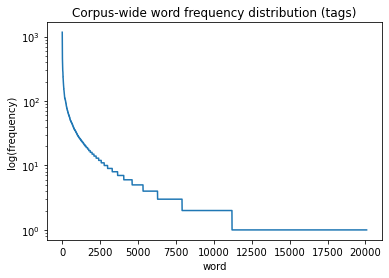

In [105]:
plotWf(tag_terms, 'tags', logscale=True)

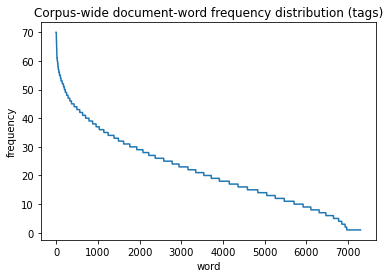

In [107]:
plotDf(df_tags, 'tags', logscale=False)

#### Description

In [100]:
%%time
df_desc, desc_terms = tf_vectorize(cdesc_stem)

CPU times: user 54.1 s, sys: 1.99 s, total: 56.1 s
Wall time: 55.3 s


In [101]:
df_desc.shape

(7302, 43029)

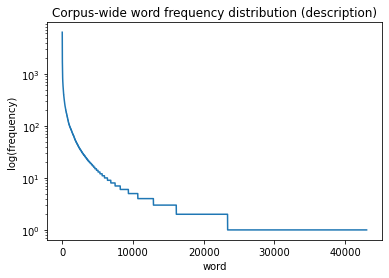

In [102]:
plotWf(desc_terms, 'description', logscale=True)

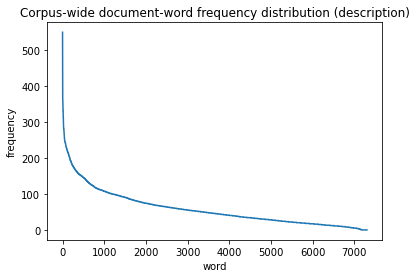

In [103]:
plotDf(df_desc, 'description', logscale=False)

#### Overlapping terms

In [108]:
overlap = set(tag_terms.keys()) & set(desc_terms.keys())
union = set(tag_terms.keys()) | set(desc_terms.keys())
print(f'{len(overlap)} overlapping terms')
print(f'{len(union)} unique terms across tags & descriptions')

12981 overlapping terms
50127 unique terms across tags & descriptions


## Feature Importance

In [20]:
d = defaultdict(set) # channel_title: category_id
for row in df_usd.itertuples():
    d[row.channel_title].add(row.category_id)

dl = [len(val) for val in d.values()]
print(f'Number of unique youtube videos (US): {len(df_usd)}')
print(f'Number of unique channels: {len(d)}')
print(f'Max # of unique categories for a channel: {max(dl)}')
print(f'Average # of unique categories per channel: {sum(dl) / len(dl)}')

Number of unique youtube videos (US): 7302
Number of unique channels: 2207
Max # of unique categories for a channel: 7
Average # of unique categories per channel: 1.0693248753964657
